## MovieLens 电影数据分析

指导教师：胡俊峰

负责助教：苏亚鲁，李浩然

致谢：孙睿涵，刘宇川，李砺涵

注意：仅需要提交.ipynb文件，请**不要**将下发压缩包中的其他文件一并交上。

截止日期：5月10日24点

### 第一部分：男女用户观影偏好分析（4分）

#### 读取moivelens 1M 数据（data目录）

In [134]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Reading ratings file
ratings = pd.read_csv('data/ratings2.csv',  encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('data/users.csv', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('data/movies.csv',  encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

In [135]:
ratings[int(1e6):int(1e6+10)]

,user_id,movie_id,rating,timestamp
1000000,6040,3552,2,956715942
1000001,6040,1952,5,957717017
1000002,6040,1954,3,960972782
1000003,6040,25,3,957717322
1000004,6040,348,2,956704972
1000005,6040,29,4,960972720
1000006,6040,1960,4,956715597
1000007,6040,1961,4,956703977
1000008,6040,1962,3,956715569
1000009,6040,1963,4,960972887


In [136]:
# Reading movies info file
movies_info = pd.read_csv('data/info.csv',  encoding='latin-1', usecols=['id', 'name', 'genre','intro','directors','starts', 'release_time'])
movies_info.rename(columns ={ 'id':'movie_id', 'starts': 'stars'}, inplace = True)
movies_info

,movie_id,name,genre,release_time,intro,directors,stars
0,1,Toy Story (1995),Animation|Adventure|Comedy,22 November 1995 (USA),A cowboy doll is profoundly threatened and jea...,John Lasseter,Tom Hanks|Tim Allen|Don Rickles
1,2,Jumanji (1995),Adventure|Comedy|Family,15 December 1995 (USA),When two kids find and play a magical board ga...,Joe Johnston,Robin Williams|Kirsten Dunst|Bonnie Hunt
2,3,Grumpier Old Men (1995),Comedy|Romance,22 December 1995 (USA),John and Max resolve to save their beloved bai...,Howard Deutch,Walter Matthau|Jack Lemmon|Ann-Margret
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,22 December 1995 (USA),"Based on Terry McMillan's novel, this film fol...",Forest Whitaker,Whitney Houston|Angela Bassett|Loretta Devine
4,5,Father of the Bride Part II (1995),Comedy|Family|Romance,8 December 1995 (USA),George Banks must deal not only with the pregn...,Charles Shyer,Steve Martin|Diane Keaton|Martin Short
...,...,...,...,...,...,...,...
9737,193581,Kuroshitsuji: Book of the Atlantic (2017),Animation,21 January 2017 (Japan),A young lord and his demon butler board a luxu...,Noriyuki Abe|Stephen Hoff,Bryn Apprill|Dawn Michelle Bennett|Justin Briner
9738,193583,NÃ´gÃªmu nÃ´raifu: Zero (2017),Animation|Adventure|Comedy,19 July 2019 (China),"Adaption of the sixth Light Novel of series, i...",Atsuko Ishizuka,Alexandra Bedford|Jessica Boone|Ricardo Contreras
9739,193585,Flint (2017),Drama,TV Movie 28 October 2017,A woman deals with the toxic water scandal in ...,Bruce Beresford,Marin Ireland|Betsy Brandt|Queen Latifah
9740,193587,Bungou Stray Dogs: Dead Apple (2018),Animation,3 March 2018 (Japan),Rivalry between groups of criminals and detect...,Takuya Igarashi,Brian Beacock|Ray Chase|Lucien Dodge


#### 1.1 结合观影信息、评分信息，分别筛选出前20部比较流行的男性/女性偏好电影。

In [137]:
# 筛选出观影人次大于300的电影
popular = ratings['movie_id'].value_counts()
popular = popular[popular > 300]
popular = popular.rename('count')
popular = popular.rename_axis('movie_id')
print("Popular:")
display(popular)

Popular:


movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
2404     301
1845     301
1012     301
535      301
2363     301
Name: count, Length: 1053, dtype: int64

In [138]:
import matplotlib.pyplot as plt

# 如何衡量偏好程度？看过某部电影的男性/女性观众对该部电影的平均打分显然是最重要的衡量依据，
# 但我们需要注意到，受“偏好”程度用男性/女性观众对该部电影的平均打分之差来衡量要比用各自的绝对值来衡量更合理。
# 但是同时，该电影的观影人次也应当有加权，比如总观影人次非常多的电影如果还呈现出明显的性别打分差异，
# 那么更能说明这部电影是明显的性别偏好电影，因为打分随机性等可能导致非内在的男女打分差异的因素影响会较弱，性别差异结果的“信度”就更高。
# 不过这一项只是辅助指标，不应成为影响最终评价函数的最主要因素。故最终我选择用 " * ln(总观影人次) " 的方式。
# 因此，我最终定义的评价函数是 " (男性观众平均打分 - 女性观众平均打分) * ln(总观影人次) " 。

# 我这里没有使用每部电影的“男性观影人次”和“女性观影人次”这两个指标，
# 是因为这会涉及男/女性观众人数不一致等问题，会带来麻烦，纵然进行归一化等操作也很难不使评价结果失真。

gender_users = pd.merge(users, ratings, on='user_id', how='outer')
gender_users = gender_users[gender_users['movie_id'].isin(popular.index)] # 只保留popular的电影

female_users = gender_users[gender_users['gender'] == 'F']
male_users = gender_users[gender_users['gender'] == 'M']

# 计算平均打分
female_mean_rating = female_users.groupby('movie_id')['rating'].mean()
male_mean_rating = male_users.groupby('movie_id')['rating'].mean()
print("Female mean rating:")
display(female_mean_rating)
print("\nMale mean rating:")
display(male_mean_rating)

# 计算评价函数
score = male_mean_rating - female_mean_rating
score = pd.merge(score, popular, on='movie_id', how='outer') # 加入总观影人次这一列
score['score'] = score['rating'] * np.log(score['count']) # score['score']这一列为评价函数
print("\nScore:")
display(score)

Female mean rating:


movie_id
1       4.187817
2       3.278409
3       3.073529
6       3.682171
7       3.588235
          ...   
3916    4.093458
3927    3.535714
3948    3.619048
3949    3.950000
3952    3.761905
Name: rating, Length: 1053, dtype: float64


Male mean rating:


movie_id
1       4.130552
2       3.175238
3       2.994152
6       3.909988
7       3.267717
          ...   
3916    3.869697
3927    3.589041
3948    3.641838
3949    4.174107
3952    3.787986
Name: rating, Length: 1053, dtype: float64


Score:


,rating,count,score
movie_id,,,
1,-0.057265,2077,-0.437432
2,-0.103171,701,-0.676029
3,-0.079377,478,-0.489727
6,0.227817,940,1.559609
7,-0.320519,458,-1.963777
...,...,...,...
3916,-0.223761,437,-1.360452
3927,0.053327,348,0.312079
3948,0.022791,862,0.154048


In [139]:
# 筛出前20名和后20名的电影，分别作为男/女性偏好的电影
male_preference = score.nlargest(20, 'score').reset_index()
female_preference = score.nsmallest(20, 'score').reset_index()
female_preference['score'] = - female_preference['score']

In [140]:
# 详细展示这些选出的电影的信息
print("男性最偏好的20部电影：")
male_preference_detail = pd.merge(male_preference, movies, on='movie_id', how='inner')
male_preference_detail = male_preference_detail.drop(['rating', 'count', 'score', 'movie_id'], axis=1) # 去除无需展示的列
male_preference_detail['ranking'] = male_preference_detail.index.to_series().apply(lambda x: x+1)
male_preference_detail = male_preference_detail.set_index('ranking') # 增加“排名”这一列，并将其设为index
display(male_preference_detail)

print("\n女性最偏好的20部电影：")
female_preference_detail = pd.merge(female_preference, movies, on='movie_id', how='inner')
female_preference_detail = female_preference_detail.drop(['rating', 'count', 'score', 'movie_id'], axis=1) # 去除无需展示的列
female_preference_detail['ranking'] = female_preference_detail.index.to_series().apply(lambda x: x+1)
female_preference_detail = female_preference_detail.set_index('ranking') # 增加“排名”这一列，并将其设为index
display(female_preference_detail)

男性最偏好的20部电影：


,title,genres
ranking,,
1,"Good, The Bad and The Ugly, The (1966)",Action|Western
2,Dumb & Dumber (1994),Comedy
3,Caddyshack (1980),Comedy
4,"Kentucky Fried Movie, The (1977)",Comedy
5,Evil Dead II (Dead By Dawn) (1987),Action|Adventure|Comedy|Horror
6,Animal House (1978),Comedy
7,"Cable Guy, The (1996)",Comedy
8,"Longest Day, The (1962)",Action|Drama|War
9,"Exorcist, The (1973)",Horror



女性最偏好的20部电影：


,title,genres
ranking,,
1,Dirty Dancing (1987),Musical|Romance
2,Grease (1978),Comedy|Musical|Romance
3,Jumpin' Jack Flash (1986),Action|Comedy|Romance|Thriller
4,"Rocky Horror Picture Show, The (1975)",Comedy|Horror|Musical|Sci-Fi
5,Mary Poppins (1964),Children's|Comedy|Musical
6,Steel Magnolias (1989),Drama
7,Gone with the Wind (1939),Drama|Romance|War
8,"Sound of Music, The (1965)",Musical
9,"Color Purple, The (1985)",Drama


#### 思考：你有没有更好的描述“流行”的统计量？请进行实现（选做）

In [141]:
# TODO

#### 1.2 针对不同类型（genres）的电影，统计分析男女偏好程度，并进行图形化对比显示。

具体包括以下步骤

（1）数据预处理：读取、合并表格

（2）将genres进行split操作，构建描述矩阵

（3）分别统计男女对不同类别电影评价的均值、标准差等统计量，并进行可视化对比分析。

#### 数据预处理

In [142]:
data = pd.merge(ratings, users, how='outer')
data = pd.merge(data, movies, how='outer')
data

,user_id,movie_id,rating,timestamp,gender,zipcode,age_desc,occ_desc,title,genres
0,1.0,1193,5.0,978300760.0,F,48067,Under 18,K-12 student,One Flew Over the Cuckoo's Nest (1975),Drama
1,2.0,1193,5.0,978298413.0,M,70072,56+,self-employed,One Flew Over the Cuckoo's Nest (1975),Drama
2,12.0,1193,4.0,978220179.0,M,32793,25-34,programmer,One Flew Over the Cuckoo's Nest (1975),Drama
3,15.0,1193,4.0,978199279.0,M,22903,25-34,executive/managerial,One Flew Over the Cuckoo's Nest (1975),Drama
4,17.0,1193,5.0,978158471.0,M,95350,50-55,academic/educator,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...
1000381,NaN,3650,NaN,NaN,NaN,NaN,NaN,NaN,Anguish (Angustia) (1986),Horror
1000382,NaN,3750,NaN,NaN,NaN,NaN,NaN,NaN,Boricua's Bond (2000),Drama
1000383,NaN,3829,NaN,NaN,NaN,NaN,NaN,NaN,Mad About Mambo (2000),Comedy|Romance
1000384,NaN,3856,NaN,NaN,NaN,NaN,NaN,NaN,Autumn Heart (1999),Drama


In [143]:
data_male = data[data.gender=='M']
data_female = data[data.gender=='F']
female_count = data_female.shape[0]
male_count = data_male.shape[0]
data_male.shape, data_female.shape

((753769, 10), (246440, 10))

#### 将genres进行split操作，构建描述矩阵

In [144]:
# 看看总共有多少个风格
genre_list = []
for i in movies.genres:
    genre = i.split(sep='|')
    genre_list += genre
genre_list = list(set(genre_list))
genre_list

['Musical',
 "Children's",
 'Crime',
 'Mystery',
 'Film-Noir',
 'Sci-Fi',
 'Animation',
 'Documentary',
 'Western',
 'Horror',
 'Action',
 'Fantasy',
 'Adventure',
 'Romance',
 'Drama',
 'War',
 'Thriller',
 'Comedy']

In [145]:
# 统计每个电影的风格
num_movies = movies.shape[0]
for genre in genre_list:
    movies[genre] = 0
for i in movies.index:
    genre = movies.loc[i].genres.split(sep='|')
    for j in genre:
        movies[j][i] = 1
movies

,movie_id,title,genres,Musical,Children's,Crime,Mystery,Film-Noir,Sci-Fi,Animation,...,Western,Horror,Action,Fantasy,Adventure,Romance,Drama,War,Thriller,Comedy
0,1,Toy Story (1995),Animation|Children's|Comedy,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3879,3949,Requiem for a Dream (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3880,3950,Tigerland (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3881,3951,Two Family House (2000),Drama,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [146]:
data_2 = pd.merge(ratings, users, how='outer')
data_2 = pd.merge(data, movies, how='outer')
data_2.shape

(1000386, 28)

In [147]:
data_2_male = data_2[data_2.gender=='M']
data_2_female = data_2[data_2.gender=='F']

data_2_male.head()

,user_id,movie_id,rating,timestamp,gender,zipcode,age_desc,occ_desc,title,genres,...,Western,Horror,Action,Fantasy,Adventure,Romance,Drama,War,Thriller,Comedy
1,2.0,1193,5.0,978298413.0,M,70072,56+,self-employed,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,1,0,0,0
2,12.0,1193,4.0,978220179.0,M,32793,25-34,programmer,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,1,0,0,0
3,15.0,1193,4.0,978199279.0,M,22903,25-34,executive/managerial,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,1,0,0,0
4,17.0,1193,5.0,978158471.0,M,95350,50-55,academic/educator,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,1,0,0,0
6,19.0,1193,5.0,982730936.0,M,48073,Under 18,K-12 student,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,1,0,0,0


In [148]:
# 初始化一个用于对比男女不同风格差异的表格
df_2 = pd.DataFrame(np.zeros((len(genre_list), 8)), index=genre_list, columns=[['Male', 'Male', 'Male', 'Male', 'Female', 'Female', 'Female', 'Female'], ['mean', 'std', 'count', 'portion', 'mean', 'std', 'count', 'portion']])
df_2

Male                    Female                   
            mean  std count portion   mean  std count portion
Musical      0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Children's   0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Crime        0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Mystery      0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Film-Noir    0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Sci-Fi       0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Animation    0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Documentary  0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Western      0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Horror       0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Action       0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Fantasy      0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Adventure    0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Romance      0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Drama        0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
War          0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Thriller     0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0
Comedy       0.0  0.0   0.0     0.0    0.0  0.0   0.0     0.0

In [149]:
# 收集每个风格的均值，分风格将数据归一化；同时收集每个genre中男性和女性评分数据
genre_rating_male = []
genre_rating_female = []
for i in genre_list:

    # 收集男性评分数据
    data_2_genre_m = data_2_male[data_2_male[i]==1]
    m_mean = data_2_genre_m.rating.mean()
    m_std = data_2_genre_m.rating.std()
    data_2_genre_m.rating = (data_2_genre_m.rating - m_mean) / m_std
    df_2.loc[i, ('Male', 'mean')] = m_mean
    df_2.loc[i, ('Male', 'std')] = m_std
    df_2.loc[i, ('Male', 'count')] = data_2_genre_m.shape[0]
    df_2.loc[i, ('Male', 'portion')] = df_2.loc[i, ('Male', 'count')] / male_count
    genre_rating_male.append(data_2_genre_m.rating.to_list())


    # 收集女性评分数据(4分)
    # TODO
    ## 归一化
    data_2_genre_f=data_2_female[data_2_female[i]==1]
    f_mean=data_2_genre_f.rating.mean()
    f_std=data_2_genre_f.rating.std()
    data_2_genre_f.rating=(data_2_genre_f.rating-f_mean)/f_std

    df_2.loc[i,('Female','mean')]=f_mean
    df_2.loc[i,('Female','std')]=f_std
    df_2.loc[i,('Female','count')]=data_2_genre_f.shape[0]
    df_2.loc[i,('Female','portion')]=df_2.loc[i,('Female','count')]/female_count
    genre_rating_female.append(data_2_genre_f.rating.to_list())



df_2

Male                                  Female            \
                 mean       std     count   portion      mean       std   
Musical      3.596332  1.117510   28028.0  0.037184  3.809108  1.051752   
Children's   3.358961  1.171177   50869.0  0.067486  3.572548  1.121722   
Crime        3.713720  1.073237   63099.0  0.083711  3.689332  1.094665   
Mystery      3.662009  1.084549   30202.0  0.040068  3.686548  1.093193   
Film-Noir    4.092254  0.920489   14059.0  0.018652  4.018087  0.970234   
Sci-Fi       3.469952  1.152751  129894.0  0.172326  3.450255  1.178171   
Animation    3.661335  1.085677   31072.0  0.041222  3.744702  1.070565   
Documentary  3.928811  1.033753    5970.0  0.007920  3.946392  1.031336   
Western      3.655120  1.096121   17206.0  0.022827  3.551913  1.114281   
Horror       3.217891  1.218729   61751.0  0.081923  3.202870  1.253795   
Action       3.491386  1.131881  211807.0  0.280997  3.490252  1.140833   
Fantasy      3.426603  1.134127   27583.0  0.036593  3.513076  1.127727   
Adventure    3.468125  1.129543  106621.0  0.141450  3.512879  1.128469   
Romance      3.573262  1.069230   97226.0  0.128986  3.673579  1.058839   
Drama        3.766589  1.045872  256376.0  0.340125  3.765662  1.045558   
War          3.893375  1.065102   54434.0  0.072216  3.893138  1.066051   
Thriller     3.569685  1.099485  149372.0  0.198167  3.573360  1.132786   
Comedy       3.503667  1.122733  260309.0  0.345343  3.571938  1.113762   

                                
               count   portion  
Musical      13505.0  0.054800  
Children's   21317.0  0.086500  
Crime        16442.0  0.066718  
Mystery       9976.0  0.040480  
Film-Noir     4202.0  0.017051  
Sci-Fi       27400.0  0.111183  
Animation    12221.0  0.049590  
Documentary   1940.0  0.007872  
Western       3477.0  0.014109  
Horror       14635.0  0.059386  
Action       45650.0  0.185238  
Fantasy       8718.0  0.035376  
Adventure    27332.0  0.110907  
Romance      50297.0  0.204094  
Drama        98153.0  0.398284  
War          14093.0  0.057186  
Thriller     40308.0  0.163561  
Comedy       96271.0  0.390647

#### 可视化展示结果

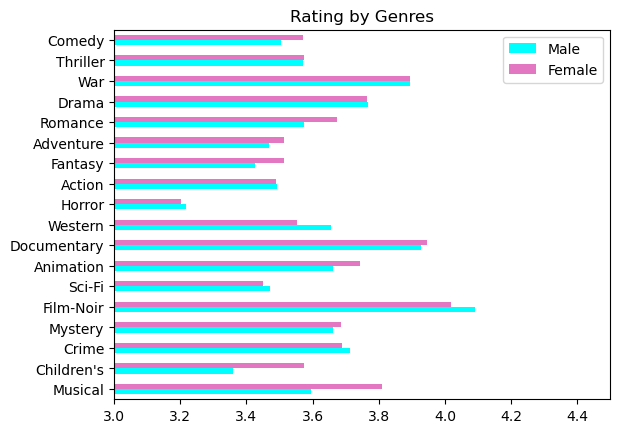

In [150]:
import matplotlib.pyplot as plt
df_2.plot.barh(y=[('Male', 'mean'), ('Female', 'mean')], color=['cyan', 'tab:pink'])
plt.title('Rating by Genres')
plt.xlim(3, 4.5)
plt.legend(['Male', 'Female'])
plt.savefig('ratings by genres.png')

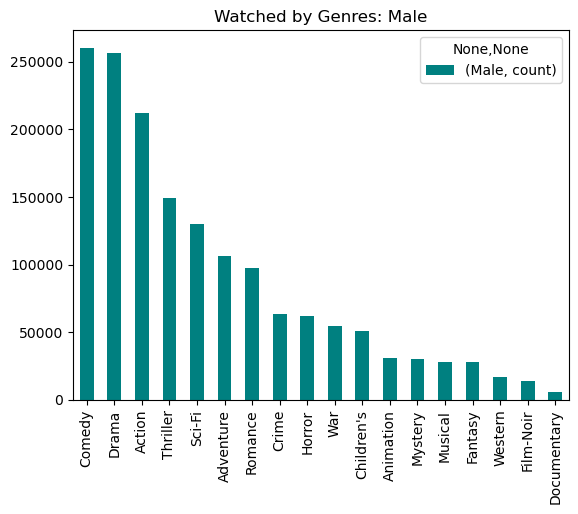

In [151]:
df_2.sort_values(by=('Male', 'count'), inplace=True, ascending=False)
df_2.plot.bar(y=('Male', 'count'), color=(0, 128/255, 128/255))
plt.title('Watched by Genres: Male')
plt.savefig('counts by genres: male.png')

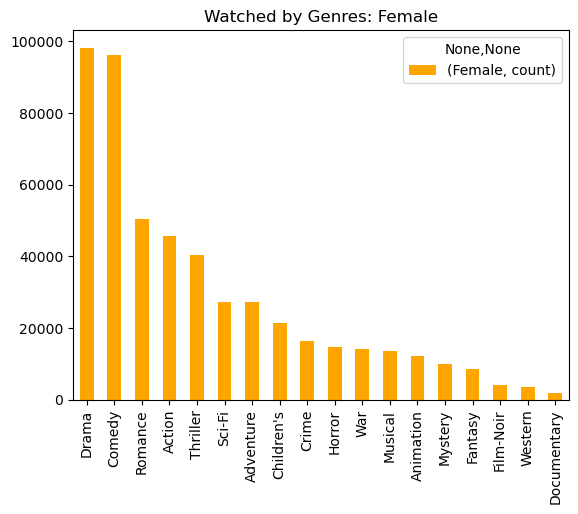

In [152]:
df_2.sort_values(by=('Female', 'count'), inplace=True, ascending=False)
df_2.plot.bar(y=('Female', 'count'), color='orange')
plt.title('Watched by Genres: Female')
plt.savefig('counts by genres: female.png')

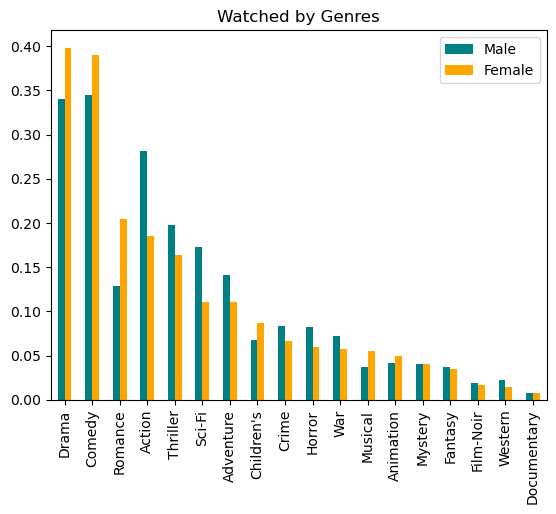

In [153]:
df_2.plot.bar(y=[('Male', 'portion'), ('Female', 'portion')], color=[(0, 128/255, 128/255), 'orange'])
plt.title('Watched by Genres')
plt.legend(['Male', 'Female'])
plt.savefig('counts by genres.png')

### 第二部分：通过观影及评分信息，手动实现KNN（K-Nearest Neighbor）算法预测观众的年龄和性别（6分）

In [154]:
from sklearn import model_selection
from sklearn.decomposition import PCA

ratings_user_stats2 = ratings.groupby('user_id').agg({'rating':'mean','movie_id':'count'})
ratings_user_stats2.rename(columns={'rating':'rating_average','movie_id':'movie_count'}, inplace = True)
# 筛选观影数超过100的用户
ratings_user_stats2 = ratings_user_stats2[ratings_user_stats2['movie_count'] > 100] 
ratings_user_stats2.insert(ratings_user_stats2.shape[1], 'index', range(ratings_user_stats2.shape[0]))
ratings_user_stats2 = ratings_user_stats2.set_index('index', append=True).reset_index(['user_id']).merge(users, left_on ='user_id', 
                                                                                                        right_on = 'user_id', how = 'left').loc[:, ['user_id', 'rating_average', 'gender', 'age_desc', 'movie_count']]
ratings_user_stats2

,user_id,rating_average,gender,age_desc,movie_count
0,2,3.713178,M,56+,129
1,5,3.146465,M,25-34,198
2,8,3.884892,M,25-34,139
3,9,3.735849,M,25-34,106
4,10,4.114713,F,35-44,401
...,...,...,...,...,...
2904,6035,2.610714,F,25-34,280
2905,6036,3.302928,F,25-34,888
2906,6037,3.717822,F,45-49,202
2907,6039,3.878049,F,45-49,123


In [155]:
from collections import Counter
from sklearn.model_selection import train_test_split
import numpy as np
import random
np.random.seed(0)
X_gender = ratings_user_stats2.loc[:, ['rating_average', 'movie_count']].values
X_age = ratings_user_stats2.loc[:, ['rating_average']].values
y_age = ratings_user_stats2.loc[:, 'age_desc'].values
y_gender = ratings_user_stats2.loc[:, 'gender'].values
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age, y_age, test_size = 0.2)
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X_gender, y_gender, test_size = 0.2)

In [156]:
def knn_classify(X, y, testInstance, k):
    # 手动实现KNN算法，注意使用向量化运算提高效率（6分）
    # 可分为四步:计算元素两两之间的距离；找出最近的K个元素的idx; 找出KNN对应的n个y值; 返回投票结果
    # TODO
    """
    使用KNN算法对给定的测试实例进行分类
    
    参数：
    X: 训练数据集特征向量组成的二维数组，每行表示一个样本的特征向量
    y: 训练数据集的标签数组，每个元素对应一个样本的类别标签
    testInstance: 要进行分类的测试实例的特征向量
    k: KNN算法的超参数，表示选取的最近邻样本数量
    
    返回值：
    predictedLabel: 预测的标签
    """
    # 计算测试实例与所有训练样本的欧氏距离
    distances = np.sqrt(np.sum((X - testInstance)**2, axis=1))
    
    # 根据距离排序，获取最近的k个样本的索引
    nearestNeighbors = np.argsort(distances)[:k]
    
    # 进行投票决定测试实例的类别
    uniqueLabels, labelCounts = np.unique(y[nearestNeighbors], return_counts=True)
    predictedLabel = uniqueLabels[np.argmax(labelCounts)]  # 获取出现次数最多的标签作为预测结果
    
    return predictedLabel


In [157]:
# K值是试验出来的
predictions_age = [knn_classify(X_train_age, y_train_age, data, 13) for data in X_test_age]
predictions_gender = [knn_classify(X_train_gender, y_train_gender, data, 24) for data in X_test_gender] 

In [158]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print(accuracy_score(y_test_age, predictions_age)) 
print(recall_score(y_test_age, predictions_age, average='micro')) 
print(accuracy_score(y_test_gender, predictions_gender)) 
print(recall_score(y_test_gender, predictions_gender, average='micro')) 

0.34536082474226804
0.34536082474226804
0.7680412371134021
0.7680412371134021


#### 思考：该KNN实现的预测结果并不理想，你有没有改进策略？（选做）

1. 特征归一化：KNN算法对特征的尺度比较敏感，因此可以尝试对特征进行归一化，使其在相同的尺度范围内。常见的归一化方法包括标准化和范围缩放。
2. 调整K值：尝试不同的K值，选择在验证集上表现最好的K值。较小的K值可以增加模型的灵敏度，但可能对噪声敏感，较大的K值可以减小噪声的影响，但可能会造成模型过于平滑。
3. 引入其他距离度量：除了欧氏距离，还可以尝试其他距离度量方法，如曼哈顿距离、闵可夫斯基距离等，根据具体情况选择适合的距离度量方法。

In [159]:
def knn_classify_improved(X, y, testInstance, k):
    # 特征归一化
    X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    testInstance_normalized = (testInstance - np.mean(X, axis=0)) / np.std(X, axis=0)

    # 计算距离
    distances = np.sqrt(np.sum((X_normalized - testInstance_normalized) ** 2, axis=1))

    # 选择最近的K个样本的索引
    nearest_indices = np.argsort(distances)[:k]

    # 获取最近的K个样本的标签和距离
    nearest_labels = y[nearest_indices]
    nearest_distances = distances[nearest_indices]

    # 进行投票决定测试实例的类别
    unique_labels, label_counts = np.unique(nearest_labels, return_counts=True)
    predicted_label = unique_labels[np.argmax(label_counts)]  # 获取出现次数最多的标签作为预测结果

    return predicted_label


In [160]:
# K值是试验出来的，遍历 k 值，选出准确率最高的 k 值
max_acc_age,max_acc_gender,maxk_age,maxk_gender=0,0,0,0
for i in range(1,200):
    predictions_age_improved = [knn_classify_improved(X_train_age, y_train_age, data, i) for data in X_test_age]
    predictions_gender_improved = [knn_classify(X_train_gender, y_train_gender, data, i) for data in X_test_gender] 
    if accuracy_score(y_test_age, predictions_age_improved)>max_acc_age:
        max_acc_age=accuracy_score(y_test_age, predictions_age_improved)
        maxk_age=i
    if accuracy_score(y_test_gender, predictions_gender_improved)>max_acc_gender:
        max_acc_gender=accuracy_score(y_test_gender, predictions_gender_improved)
        maxk_gender=i
print(maxk_age,maxk_gender)
predictions_age_improved = [knn_classify_improved(X_train_age, y_train_age, data, maxk_age) for data in X_test_age]
predictions_gender_improved = [knn_classify(X_train_gender, y_train_gender, data, maxk_gender) for data in X_test_gender] 
print(accuracy_score(y_test_age, predictions_age_improved)) 
print(recall_score(y_test_age, predictions_age_improved, average='micro')) 
print(accuracy_score(y_test_gender, predictions_gender_improved)) 
print(recall_score(y_test_gender, predictions_gender_improved, average='micro')) 


83 27
0.3900343642611684
0.3900343642611684
0.7697594501718213
0.7697594501718213
